# ERIS gvAPP with polishing error simulation

David Doelman // 2020 November 04 // Leiden Observatory


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from hcipy import *

In [5]:
vAPP_phase = read_fits('ERIS_final_gvAPP.fits.gz')
ERIS_pupil = read_fits('ERIS_final_amplitude.fits.gz')

Nx = ERIS_pupil.shape[0]

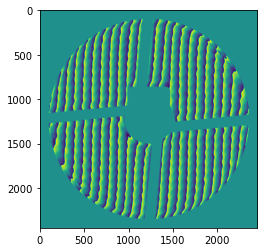

In [6]:
plt.imshow(vAPP_phase)
plt.show()

In [7]:
pupil_grid = make_pupil_grid(Nx)
focal_grid = make_focal_grid(6,50)

prop = FraunhoferPropagator(pupil_grid,focal_grid)

phase = Field(vAPP_phase.ravel(),pupil_grid)
pupil = Field(ERIS_pupil.ravel(),pupil_grid)

In [8]:
Ein = pupil * np.exp(1j * phase)

wf = Wavefront(Ein)

Efp = prop(wf)

PSF = Efp.intensity

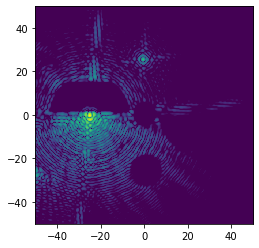

In [9]:
imshow_field(np.log10(PSF / PSF.max()), vmin = -5)
plt.show()

This is only for one polarization state!
Now we switch to the recent vector implementation of the vAPP with unpolarized light.
Add the aberration here.

/opt/anaconda3/lib/python3.7/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


The RMS of the wavefront = 594.0 nm at 2 micron


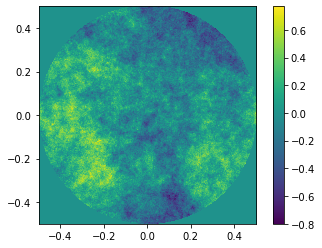

In [10]:
# add the aberration here
# aberration = ...
# E_aber = pupil * np.exp(1j * aberration)

aberration = make_power_law_error(pupil_grid,0.5*np.pi,1,exponent=-2.5)
E_aber = pupil * np.exp(1j* aberration)

RMS_rad = np.sqrt(np.mean(aberration**2))
RMS_wave = RMS_rad * ((2*np.pi) / 2.) * 1000
print('The RMS of the wavefront = {0} nm at 2 micron'.format(np.round(RMS_wave)))

imshow_field(aberration)
plt.colorbar()
plt.show()

# Define the wavefront with unpolarized light
wf_aber = Wavefront(E_aber, input_stokes_vector = (1,0,0,0))

In [11]:
# Defining the properties of the vAPP
fast_axis_orientation = phase / 2
phase_retardation = np.pi*0.93 #<--- Change the leakage here: 0.93 ~ 1%, 0.91 ~ 2% 
circularity = 0

# Making the vAPP
vAPP_pol = PhaseRetarder(phase_retardation, fast_axis_orientation, circularity)

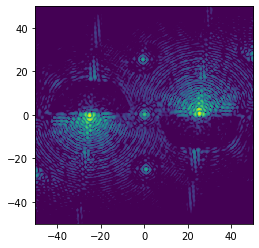

In [12]:
# Calculating the wavefront after the vAPP
wf_out = vAPP_pol.forward(wf_aber)

# Propagating the wavefront to the image plane and calculating the intensity
vAPP_PSF = prop(wf_out).I

imshow_field(np.log10(vAPP_PSF / vAPP_PSF.max()), vmin = -4.5)
plt.show()